# Visulization

In [2]:
#Import Required Libraries

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from datetime import datetime


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load Dataset
df = pd.read_csv('D:/MBA/Project/Data set/merged_file_2.csv')

### Exploratory Data Analysis

In [5]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0.1           int64  
 1   Unnamed: 0             int64  
 2   trans_date_trans_time  object 
 3   cc_num                 int64  
 4   merchant               object 
 5   category               object 
 6   amt                    float64
 7   first                  object 
 8   last                   object 
 9   gender                 object 
 10  street                 object 
 11  city                   object 
 12  state                  object 
 13  zip                    int64  
 14  lat                    float64
 15  long                   float64
 16  city_pop               int64  
 17  job                    object 
 18  dob                    object 
 19  trans_num              object 
 20  unix_time              int64  
 21  merch_lat              float64
 22  merc

In [6]:
# Drop Unnecessary Columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

#### Feature Engineering

In [7]:
# Extract DateTime Features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['transaction_month'] = df['trans_date_trans_time'].dt.month
df['is_weekend'] = df['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

In [8]:
# Categorize time of transaction
def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
df['part_of_day'] = df['transaction_hour'].apply(categorize_part_of_day)

In [9]:
# Convert 'dob' to age
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
reference_date = datetime(2020, 12, 31)
df['age'] = (reference_date - df['dob']).dt.days // 365

# Categorize age groups
def categorize_age_group(age):
    if age <= 12:
        return 'Child'
    elif 13 <= age <= 17:
        return 'Teenager'
    elif 18 <= age <= 25:
        return 'Young Adult'
    elif 26 <= age <= 40:
        return 'Adult'
    elif 41 <= age <= 60:
        return 'Middle-Aged'
    elif 61 <= age <= 80:
        return 'Senior'
    else:
        return 'Elderly'

df['age_group'] = df['age'].apply(categorize_age_group)

In [10]:
# Calculate Distance Between Cardholder and Merchant
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6371 * c  # Radius of Earth in km

df['distance'] = calculate_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

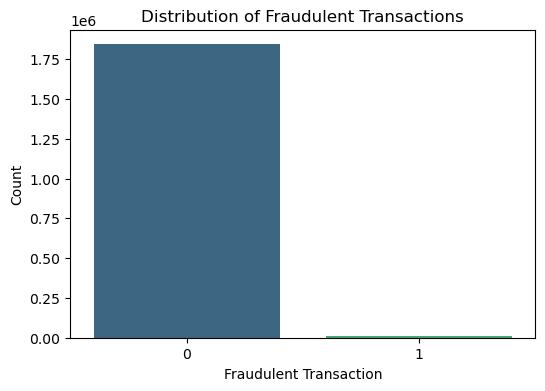

In [11]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df, palette='viridis')
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Count')
plt.show()

- The dataset is highly imbalanced, with non-fraudulent transactions far outnumbering fraudulent ones. To improve model performance, techniques like oversampling, undersampling, or anomaly detection may be required to handle this imbalance effectively.

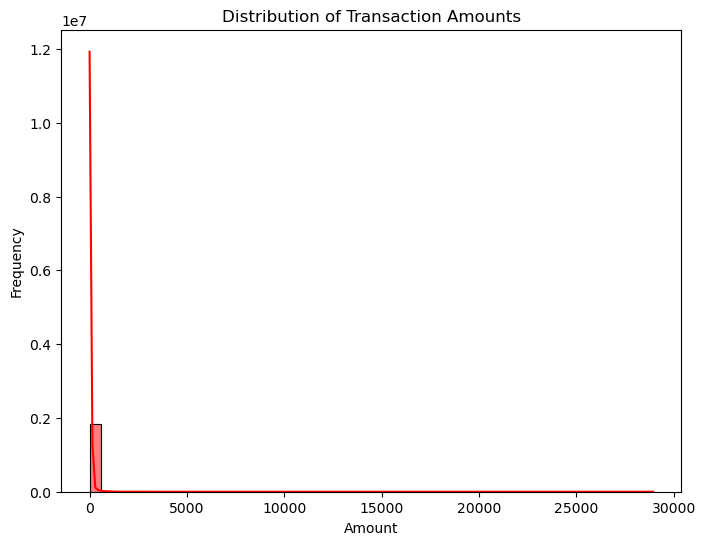

In [12]:
# Plot the distribution of the transaction amount
plt.figure(figsize=(8, 6))
sns.histplot(df['amt'], kde=True, color='red', bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

**Distribution of Transaction Amounts:**
The histogram shows that most transactions involve small amounts, while very few transactions have significantly higher values. This skewed distribution suggests that high-value transactions might be worth investigating for potential fraud.

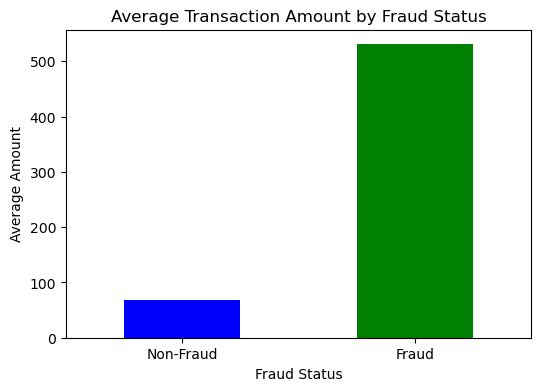

In [13]:
# Group by 'is_fraud' and calculate the mean transaction amount
avg_amt_fraud = df.groupby('is_fraud')['amt'].mean()

# Plot the result
avg_amt_fraud.plot(kind='bar', color=['blue', 'green'], figsize=(6, 4))
plt.title('Average Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Average Amount')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

**Average Transaction Amount by Fraud Status:**
The bar chart compares the average transaction amount for fraudulent and non-fraudulent transactions. Fraudulent transactions tend to have much higher average amounts compared to non-fraudulent ones, reinforcing the idea that larger transactions may be more susceptible to fraud.

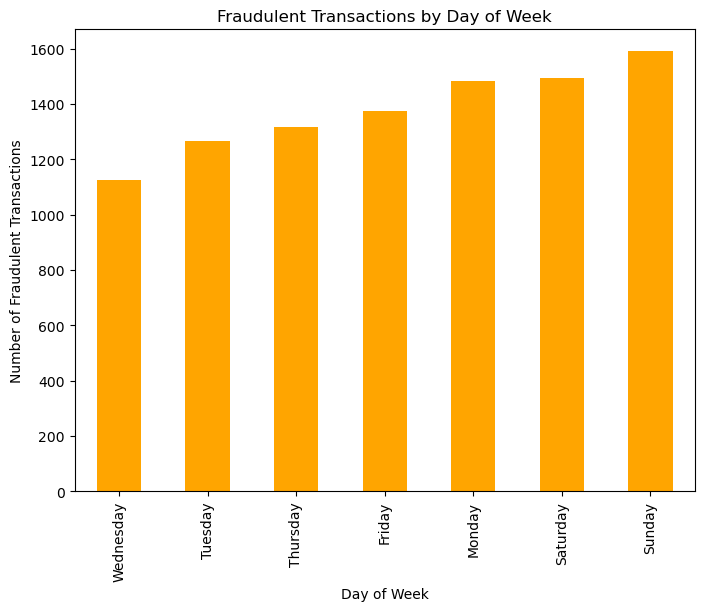

In [14]:
# Group by 'day_of_week' and calculate the sum of fraudulent transactions
fraud_by_day = df.groupby('day_of_week')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(8, 6))
fraud_by_day.sort_values().plot(kind='bar', color='orange')
plt.title('Fraudulent Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

- Fraudulent transactions tend to be more common on weekends.

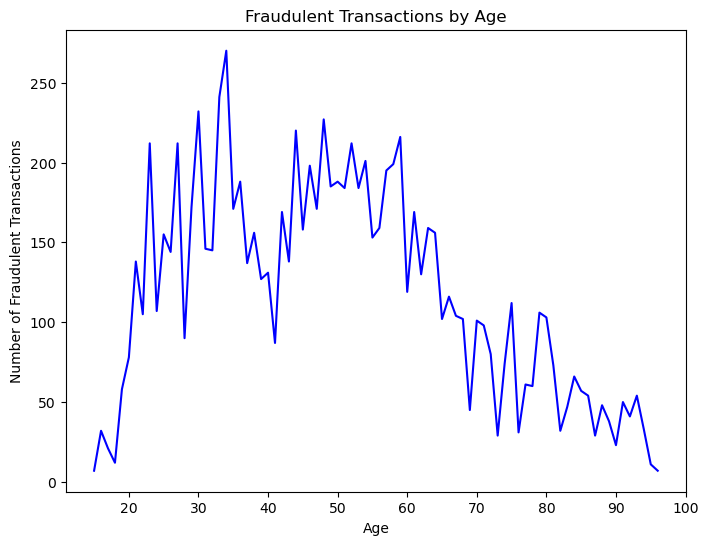

In [15]:
# Group by age and calculate the sum of fraudulent transactions
fraud_by_age = df.groupby('age')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(8, 6))
fraud_by_age.plot(kind='line', color='blue')
plt.title('Fraudulent Transactions by Age')
plt.xlabel('Age')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

**Fraudulent Transactions by Age:**
The line plot indicates that fraudulent transactions are more frequent among individuals aged 30 to 60, with a peak around 35 to 40 years old. The frequency declines for younger and older age groups.

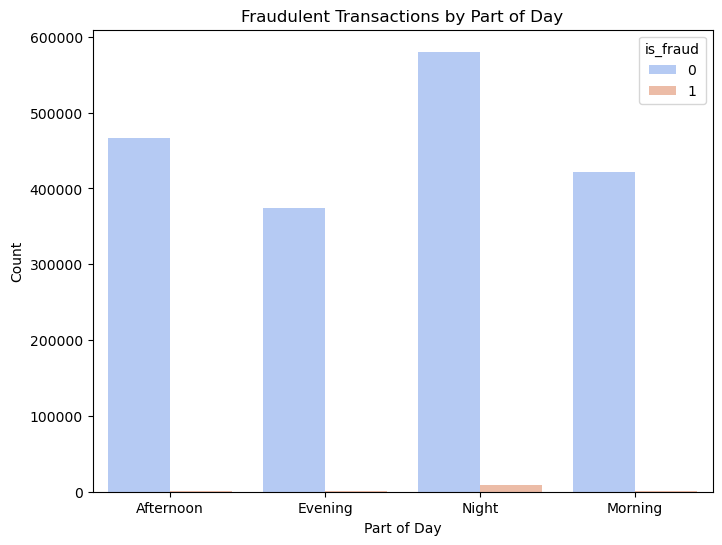

In [16]:
# Plot the distribution of fraud by part of the day
plt.figure(figsize=(8, 6))
sns.countplot(x='part_of_day', hue='is_fraud', data=df, palette='coolwarm')
plt.title('Fraudulent Transactions by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

- Fraudulent transactions are more frequent during nighttime.

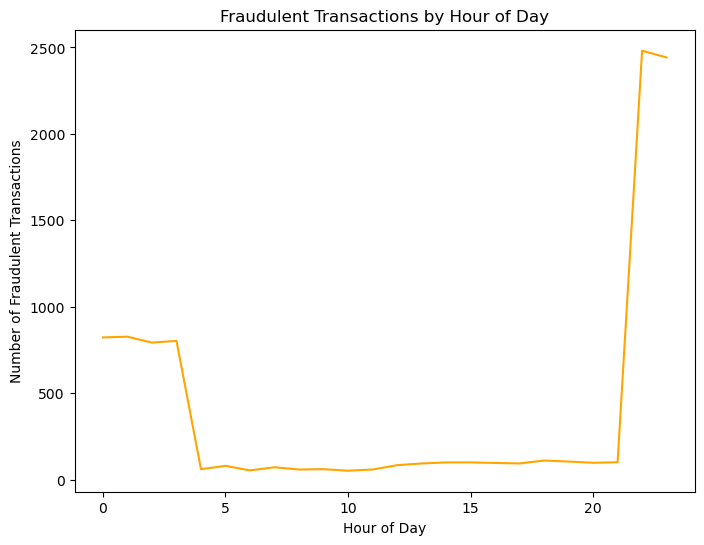

In [17]:
# Group by 'transaction_hour' and calculate the sum of fraudulent transactions
fraud_by_hour = df.groupby('transaction_hour')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(8, 6))
fraud_by_hour.plot(kind='line', color='orange')
plt.title('Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

- The highest number of fraudulent transactions occur around the 22nd hour.

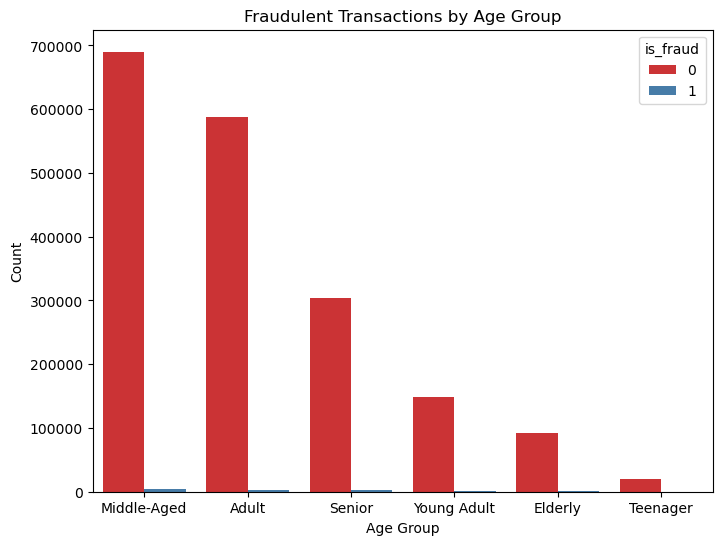

In [18]:
# Plot fraud distribution by age group
plt.figure(figsize=(8, 6))
sns.countplot(x='age_group', hue='is_fraud', data=df, palette='Set1')
plt.title('Fraudulent Transactions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

- Middle-aged individuals experience a higher number of fraudulent transactions.

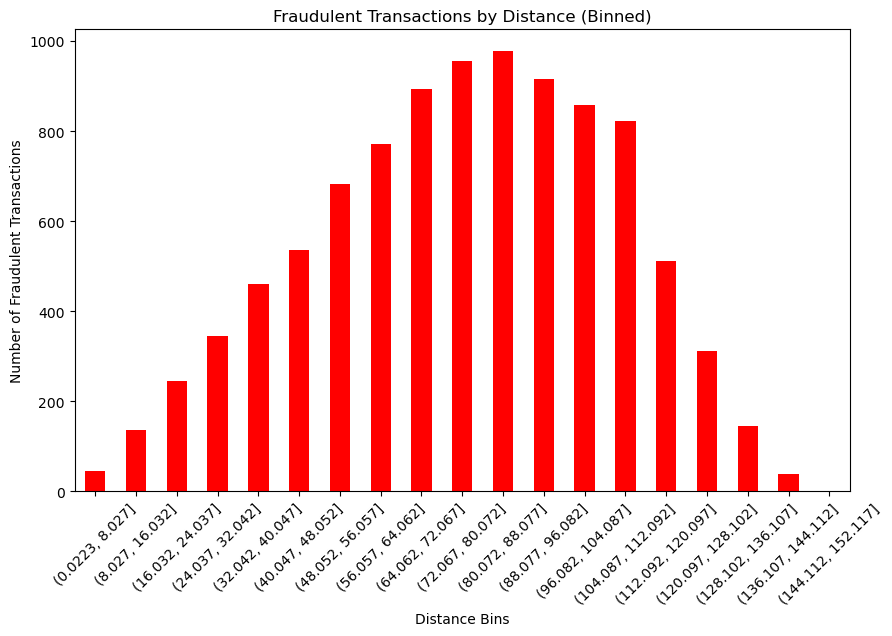

In [19]:
distance_bins = np.linspace(df['distance'].min(), df['distance'].max(), num=20)
# Bin the 'distance' column
df['distance_bin'] = pd.cut(df['distance'], bins=distance_bins)

# Group by distance bins and calculate the sum of fraudulent transactions
fraud_by_distance_bin = df.groupby('distance_bin')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(10, 6))
fraud_by_distance_bin.plot(kind='bar', color='red')
plt.title('Fraudulent Transactions by Distance (Binned)')
plt.xlabel('Distance Bins')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

- Fraudulent transactions are more common at distances of around 70-80 km.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time             